In [1]:
import os
import json
import gc
import torch
import random
import numpy as np
import torch.nn.functional as F
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
from transformers import AutoTokenizer, AutoModelForCausalLM
from statsmodels.stats.proportion import proportions_ztest
from sentences import location_sentences, love_hate_sentences

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open('./pythia_token_str_type.json', 'r') as f:
    pythia_token_str_type = json.load(f)
with open('./gpt2_token_str_type.json', 'r') as f:
    gpt2_token_str_type = json.load(f)

In [2]:
def get_weighted_cosine_similarity(embedding_matrix, token_ids, token_probs, target_ids):
    """
    Calculate weighted cosine similarity using matrix operations
    Args:
        embedding_matrix: model's embedding matrix
        token_ids: output token ids
        token_probs: probability weights for output tokens
        target_ids: target token ids to compare against
    """
    # Get embeddings for both sets of tokens
    output_token_embeddings = embedding_matrix[token_ids]  # shape: [n_tokens, embed_dim]
    target_token_embeddings = embedding_matrix[target_ids]  # shape: [n_targets, embed_dim]
    
    # Normalize embeddings
    output_token_embeddings = F.normalize(output_token_embeddings, p=2, dim=1)
    target_token_embeddings = F.normalize(target_token_embeddings, p=2, dim=1)
    
    # Calculate cosine similarity matrix using matmul
    similarity_matrix = torch.matmul(output_token_embeddings, target_token_embeddings.T)
    
    # Get max similarity for each output token
    max_similarities = torch.max(similarity_matrix, dim=1)[0]  # shape: [n_tokens]
    
    if not isinstance(token_probs, torch.Tensor):
        token_probs_tensor = torch.tensor(token_probs, device=max_similarities.device)
    else:
        token_probs_tensor = token_probs.clone().detach().to(max_similarities.device)
    
    # Apply token probabilities as weights
    weighted_similarities = max_similarities * token_probs_tensor
    
    # Sum up all weighted similarities
    total_similarity = torch.sum(weighted_similarities).item()
    
    return total_similarity

def get_weighted_overlap(token_ids, target_ids, token_probs):
    """Calculate weighted overlap between token_ids and target_ids"""
    overlap = 0
    for i, token_id in enumerate(token_ids):
        if token_id in target_ids:
            overlap += token_probs[i]
    return overlap

def get_best_rank(token_ids, target_ids):
    """Calculate best rank of target tokens in token_ids"""
    best_rank = None
    for i, token_id in enumerate(token_ids):
        if token_id in target_ids:
            if best_rank is None or i < best_rank:
                best_rank = i
    return best_rank

def inject_tokens(sentence, tokens):
    """Inject tokens into sentence"""
    return f"({''.join(tokens)}){sentence}"

def get_next_token_probs(model, tokenizer, text, top_k=10):
    """Get next token predictions with probabilities"""
    inputs = tokenizer(text, return_tensors="pt").to(model.device)
    
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits[0, -1, :]
        probs = torch.softmax(logits, dim=-1)
        top_k_probs, top_k_indices = torch.topk(probs, top_k)
        
        result = []
        for idx, prob in zip(top_k_indices, top_k_probs):
            token_str = tokenizer.decode(idx)
            result.append((idx.item(), token_str, prob.item()))
        
        return result

In [ ]:
def run_injection_experiment(model, tokenizer, sentence, injection_tokens, n_trials, target_ids):
    """
    Run injection experiments with multiple metrics
    """
    results = {
        'count_increases': 0,
        'prob_increases': 0,
        'total_trials': n_trials,
        'detailed_metrics': []
    }
    
    # Get original predictions
    original_top_k = get_next_token_probs(model, tokenizer, sentence)
    original_ids = [t[0] for t in original_top_k]
    original_probs = [t[2] for t in original_top_k]
    
    # Calculate original metrics
    original_count = sum(1 for tid in original_ids if tid in target_ids)
    original_prob = sum(p for tid, p in zip(original_ids, original_probs) if tid in target_ids)
    
    embedding_matrix = model.get_input_embeddings().weight.detach()
    original_sim = get_weighted_cosine_similarity(
        embedding_matrix,
        torch.tensor(original_ids),
        torch.tensor(original_probs),
        torch.tensor(target_ids)
    )
    
    original_overlap = get_weighted_overlap(
        original_ids,
        target_ids,
        original_probs
    )
    
    original_best_rank = get_best_rank(original_ids, target_ids)
    
    # Run trials
    for _ in range(n_trials):
        selected_tokens = random.sample(injection_tokens, 10)
        injected_sentence = inject_tokens(sentence, selected_tokens)
        
        injected_top_k = get_next_token_probs(model, tokenizer, injected_sentence)
        injected_ids = [t[0] for t in injected_top_k]
        injected_probs = [t[2] for t in injected_top_k]
        
        injected_count = sum(1 for tid in injected_ids if tid in target_ids)
        injected_prob = sum(p for tid, p in zip(injected_ids, injected_probs) if tid in target_ids)
        
        injected_sim = get_weighted_cosine_similarity(
            embedding_matrix,
            torch.tensor(injected_ids),
            torch.tensor(injected_probs),
            torch.tensor(target_ids)
        )
        
        injected_overlap = get_weighted_overlap(
            injected_ids,
            target_ids,
            injected_probs
        )
        
        injected_best_rank = get_best_rank(injected_ids, target_ids)
        
        trial_metrics = {
            'injected_tokens': selected_tokens,
            'injected_top_k': injected_top_k,
            'original_count': original_count,
            'injected_count': injected_count,
            'original_prob': original_prob,
            'injected_prob': injected_prob,
            'similarity_change': float(injected_sim - original_sim),
            'overlap_change': float(injected_overlap - original_overlap),
            'rank_change': None if original_best_rank is None or injected_best_rank is None 
                          else float(original_best_rank - injected_best_rank)
        }
        results['detailed_metrics'].append(trial_metrics)
        
        if injected_count > original_count:
            results['count_increases'] += 1
        if injected_prob > original_prob:
            results['prob_increases'] += 1
            
    return results

def print_experiment_results(results_dict, model_name, exp_type):
    """
    Print success rates for all interference levels
    Args:
        results_dict: experiment results dictionary
        model_name: model name (Llama/Gemma)
        exp_type: experiment type (location/love_hate)
    """
    print(f"\n=== {model_name} {exp_type} Experiment Results ===")
    token_types = ['target', 'high_interference', 'medium_interference', 'random']
    
    # Compute total trials
    total_trials = results_dict['target'][0]['results']['total_trials'] * len(results_dict['target'])
    
    for token_type in token_types:
        count_increases = sum(result['results']['count_increases'] 
                            for result in results_dict[token_type])
        prob_increases = sum(result['results']['prob_increases'] 
                           for result in results_dict[token_type])
        
        count_success_rate = (count_increases / total_trials) * 100
        prob_success_rate = (prob_increases / total_trials) * 100
        
        print(f"\n{token_type}:")
        print(f"Top-10 token count increase rate: {count_success_rate:.2f}% ({count_increases}/{total_trials})")
        print(f"Top-10 token probability sum increase rate: {prob_success_rate:.2f}% ({prob_increases}/{total_trials})")

def plot_injection_metrics(results, model_name, exp_type):
    """
    Plot injection metrics comparison for different token sets
    Only consider positive changes (improvements)
    Args:
        results: experiment results dictionary
        model_name: model name (Llama/Gemma)
        exp_type: experiment type (location/love_hate)
    """
    token_sets = ['target', 'high_interference', 'medium_interference', 'random']
    display_labels = ['Original', 'High', 'Low', 'Random']
    metrics = {
        'similarity': {'name': 'Semantic Similarity', 'ylabel': 'Mean Similarity Improvement', 'data': defaultdict(list)},
        'overlap': {'name': 'Token Overlap', 'ylabel': 'Mean Overlap Improvement', 'data': defaultdict(list)},
        'rank': {'name': 'Best Rank Change', 'ylabel': 'Mean Rank Improvement', 'data': defaultdict(list)}
    }
    
    # Choose colors based on model
    if model_name.lower() == "llama":
        # Purple style
        colors = ['#4A148C', '#6A1B9A', '#7B1FA2', '#8E24AA']
    else:  # Gemma
        # Orange style
        colors = ['#E65100', '#EF6C00', '#F57C00', '#FB8C00']
    
    # Collect only positive metric changes
    for token_type in token_sets:
        for result in results[token_type]:
            for record in result['results']['detailed_metrics']:
                if record['similarity_change'] > 0:
                    metrics['similarity']['data'][token_type].append(record['similarity_change'])
                if record['overlap_change'] > 0:
                    metrics['overlap']['data'][token_type].append(record['overlap_change'])
                if record['rank_change'] is not None and record['rank_change'] > 0:
                    metrics['rank']['data'][token_type].append(record['rank_change'])
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=300)
    
    for idx, (metric_key, metric_info) in enumerate(metrics.items()):
        ax = axes[idx]
        means = []
        sems = []
        
        for token_type in token_sets:
            data = metric_info['data'][token_type]
            if len(data) > 0:
                means.append(np.mean(data))
                sems.append(np.std(data) / np.sqrt(len(data)))
            else:
                means.append(0)
                sems.append(0)
        
        x_pos = np.arange(len(token_sets))
        bars = ax.bar(x_pos, means, color=colors,
                     yerr=sems, capsize=5,
                     error_kw={'ecolor': 'black', 'linewidth': 1, 'capthick': 1})
        
        # Add value labels
        for idx, bar in enumerate(bars):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + sems[idx],
                   f'{height:.3f}', ha='center', va='bottom', 
                   fontsize=8)
        
        ax.set_xlabel('Token Interference Level', fontsize=10)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(display_labels)
        ax.grid(axis='y', linestyle='-', alpha=0.2)
        ax.set_ylabel(metric_info['ylabel'], fontsize=10)
    
    plt.tight_layout()
    plt.show()

def plot_best_improvements(results, model_name, exp_type):
    """
    Plot best improvement distributions for each metric across sentences
    Args:
        results: experiment results dictionary
        model_name: model name (Llama/Gemma)
        exp_type: experiment type (location/love_hate)
    """
    token_sets = ['target', 'high_interference', 'medium_interference', 'random']
    display_labels = ['Original', 'High', 'Low', 'Random']
    metrics = {
        'similarity': {'name': 'Semantic Similarity', 'ylabel': 'Best Similarity Improvement', 'data': defaultdict(list)},
        'overlap': {'name': 'Token Overlap', 'ylabel': 'Best Overlap Improvement', 'data': defaultdict(list)},
        'rank': {'name': 'Best Rank', 'ylabel': 'Best Rank Improvement', 'data': defaultdict(list)}
    }
    
    # Choose colors based on model
    if model_name.lower() == "llama":
        # Purple style
        colors = ['#4A148C', '#6A1B9A', '#7B1FA2', '#8E24AA']
    else:  # Gemma
        # Orange style
        colors = ['#E65100', '#EF6C00', '#F57C00', '#FB8C00']
    
    # Get best improvements for each sentence
    for token_type in token_sets:
        for sentence_result in results[token_type]:
            best_sim_change = float('-inf')
            best_overlap_change = float('-inf')
            best_rank_change = float('-inf')
            
            for record in sentence_result['results']['detailed_metrics']:
                sim_change = record['similarity_change']
                if sim_change > best_sim_change:
                    best_sim_change = sim_change
                    
                overlap_change = record['overlap_change']
                if overlap_change > best_overlap_change:
                    best_overlap_change = overlap_change
                    
                if record['rank_change'] is not None:
                    rank_change = record['rank_change']
                    if rank_change > best_rank_change:
                        best_rank_change = rank_change
            
            if best_sim_change > float('-inf'):
                metrics['similarity']['data'][token_type].append(best_sim_change)
            if best_overlap_change > float('-inf'):
                metrics['overlap']['data'][token_type].append(best_overlap_change)
            if best_rank_change > float('-inf'):
                metrics['rank']['data'][token_type].append(best_rank_change)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=300)
    
    for idx, (metric_key, metric_info) in enumerate(metrics.items()):
        ax = axes[idx]
        means = []
        sems = []
        
        for token_type in token_sets:
            data = metric_info['data'][token_type]
            means.append(np.mean(data))
            sems.append(np.std(data) / np.sqrt(len(data)))
        
        x_pos = np.arange(len(token_sets))
        bars = ax.bar(x_pos, means, color=colors,
                     yerr=sems, capsize=5,
                     error_kw={'ecolor': 'black', 'linewidth': 1, 'capthick': 1})
        
        # Add value labels
        for idx, bar in enumerate(bars):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + sems[idx],
                   f'{height:.3f}', ha='center', va='bottom', 
                   fontsize=8)
        
        ax.set_xlabel('Token Interference Level', fontsize=10)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(display_labels)
        ax.grid(axis='y', linestyle='-', alpha=0.2)
        ax.set_ylabel(metric_info['ylabel'], fontsize=10)
    
    plt.tight_layout()
    plt.show()
    

def compare_binary_sequences(seq1, seq2, alpha=0.05, method='proportion'):
    """Compare two binary sequences using statistical tests"""
    seq1 = np.array(seq1)
    seq2 = np.array(seq2)
    
    if not np.all(np.isin(seq1, [0, 1])) or not np.all(np.isin(seq2, [0, 1])):
        raise ValueError("sequences must only contain 0s and 1s")
    
    mean1 = np.mean(seq1)
    mean2 = np.mean(seq2)
    
    count1 = np.sum(seq1)
    count2 = np.sum(seq2)
    nobs1 = len(seq1)
    nobs2 = len(seq2)
    
    if method == 'proportion':
        count = np.array([count1, count2])
        nobs = np.array([nobs1, nobs2])
        stat, pvalue = proportions_ztest(count, nobs)
        
    return {
        'mean1': mean1,
        'mean2': mean2,
        'difference': mean1 - mean2,
        'p_value': pvalue,
        'significant': pvalue < alpha,
        'conclusion': f"difference is {'significant' if pvalue < alpha else 'not significant'} (p = {pvalue:.4f})"
    }

def compare_all_groups(results, exp_type, model_name):
    """
    Compare metrics between different token groups and random baseline
    """
    # Initialize binary sequences preserving temporal order
    group_sequences = {
        'target': [],
        'high_interference': [],
        'medium_interference': [],
        'random': []
    }
    
    # Convert results to binary sequences maintaining order
    for group in group_sequences:
        for result in results[group]:
            for record in result['results']['detailed_metrics']:
                count_increased = 1 if record['injected_count'] > record['original_count'] else 0
                group_sequences[group].append(count_increased)
    
    # Run statistical tests comparing with random baseline
    target_vs_random = compare_binary_sequences(
        group_sequences['target'], 
        group_sequences['random']
    )
    high_vs_random = compare_binary_sequences(
        group_sequences['high_interference'],
        group_sequences['random']
    )
    medium_vs_random = compare_binary_sequences(
        group_sequences['medium_interference'],
        group_sequences['random']
    )
    
    print(f"\n=== {model_name} {exp_type} Statistical Analysis ===")
    print("\nTarget vs Random:")
    print(f"Difference: {target_vs_random['difference']:.4f}")
    print(f"p-value: {target_vs_random['p_value']:.4f}")
    print(f"Statistical significance: {target_vs_random['conclusion']}")
    
    print("\nHigh Interference vs Random:")
    print(f"Difference: {high_vs_random['difference']:.4f}")
    print(f"p-value: {high_vs_random['p_value']:.4f}")
    print(f"Statistical significance: {high_vs_random['conclusion']}")
    
    print("\nMedium Interference vs Random:")
    print(f"Difference: {medium_vs_random['difference']:.4f}")
    print(f"p-value: {medium_vs_random['p_value']:.4f}")
    print(f"Statistical significance: {medium_vs_random['conclusion']}")

### Initialize Model Instance

In [ ]:
llama_path = '/home/USERNAME/.cache/huggingface/hub/models--meta-llama--Llama-3.1-8B-Instruct/snapshots/0e9e39f249a16976918f6564b8830bc894c89659'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

llama = AutoModelForCausalLM.from_pretrained(
    llama_path,
    torch_dtype=torch.bfloat16,
    device_map='auto'
)
llama.eval()
tokenizer = AutoTokenizer.from_pretrained(llama_path)
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
gemma_path = '/home/USERNAME/.cache/huggingface/hub/models--google--gemma-2-9b-it/snapshots/11c9b309abf73637e4b6f9a3fa1e92e615547819'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gemma = AutoModelForCausalLM.from_pretrained(
    gemma_path,
    torch_dtype=torch.bfloat16,
    device_map='auto'
)
gemma.eval()
tokenizer = AutoTokenizer.from_pretrained(gemma_path)
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

### Location Experiment

In [5]:
with open('./corpus/pythia_non_location_interference.json', 'r') as f:
    pythia_non_location_interference = json.load(f)
with open('./corpus/gpt2_non_location_interference.json', 'r') as f:
    gpt2_non_location_interference = json.load(f)

# Get location token sets from both models
pythia_location_tokens = []
pythia_location_ids = []
for token_str, token_type in pythia_token_str_type.items():
    if token_type == 'location':
        pythia_location_tokens.append(token_str)

gpt2_location_tokens = []
gpt2_location_ids = []
for token_str, token_type in gpt2_token_str_type.items():
    if token_type == 'location':
        gpt2_location_tokens.append(token_str)

# Get intersection of location tokens
common_location_tokens = list(set(pythia_location_tokens) & set(gpt2_location_tokens))

# Get high/medium interference tokens intersection
pythia_loc_high = set()
pythia_loc_low = set()
for layer_type, layer_data in pythia_non_location_interference.items():
    for layer_id, pairs in layer_data.items():
        for pair in pairs:
            if pair['interference_value'] > 0.5:
                pythia_loc_high.add(pair['interfering_token'])
            elif pair['interference_value'] > 0.2:
                pythia_loc_low.add(pair['interfering_token'])

gpt2_loc_high = set()
gpt2_loc_low = set()
for layer_type, layer_data in gpt2_non_location_interference.items():
    for layer_id, pairs in layer_data.items():
        for pair in pairs:
            if pair['interference_value'] > 0.5:
                gpt2_loc_high.add(pair['interfering_token'])
            elif pair['interference_value'] > 0.2:
                gpt2_loc_low.add(pair['interfering_token'])

# Get common interference tokens
common_high_interference = list(pythia_loc_high & gpt2_loc_high)
common_medium_interference = list(pythia_loc_low & gpt2_loc_low)

# Get common random tokens
common_random = list(
    set(pythia_token_str_type.keys()) & set(gpt2_token_str_type.keys()) - 
    set(common_location_tokens) - set(common_high_interference) - 
    set(common_medium_interference)
)

# Prepare token sets for experiments
location_token_sets = {
    'target': common_location_tokens,
    'high_interference': common_high_interference,
    'medium_interference': common_medium_interference,
    'random': common_random
}

print("\n=== Location Token Sets Statistics ===")
print(f"Common target tokens: {len(location_token_sets['target'])}")
print(f"Common high interference tokens: {len(location_token_sets['high_interference'])}")
print(f"Common medium interference tokens: {len(location_token_sets['medium_interference'])}")
print(f"Common random tokens: {len(location_token_sets['random'])}")


=== Location Token Sets Statistics ===
Common target tokens: 654
Common high interference tokens: 199
Common medium interference tokens: 16569
Common random tokens: 19380


In [6]:
# Run location experiments
n_trials = 100

# Convert target tokens to IDs for both models
llama_location_ids = []
for token in location_token_sets['target']:
    token_id = tokenizer(token, add_special_tokens=False)['input_ids']
    if token_id:
        llama_location_ids.append(token_id[0])

# Run Llama location experiments
print("\n=== Running Llama Location Experiments ===")
llama_location_results = {token_type: [] for token_type in location_token_sets.keys()}

for sentence in tqdm(location_sentences[:100]):
    torch.cuda.empty_cache()
    
    for token_type, tokens in location_token_sets.items():
        results = run_injection_experiment(
            llama, tokenizer, sentence,
            tokens, n_trials, llama_location_ids
        )
        llama_location_results[token_type].append({
            'sentence': sentence,
            'results': results
        })


=== Running Llama Location Experiments ===


  0%|          | 0/100 [00:00<?, ?it/s]


=== Location Experiments Analysis ===

=== llama location Statistical Analysis ===

Target vs Random:
Difference: 0.2729
p-value: 0.0000
Statistical significance: difference is significant (p = 0.0000)

High Interference vs Random:
Difference: 0.0731
p-value: 0.0000
Statistical significance: difference is significant (p = 0.0000)

Medium Interference vs Random:
Difference: -0.0028
p-value: 0.6219
Statistical significance: difference is not significant (p = 0.6219)

=== llama location Experiment Results ===

target:
Top-10 token count increase rate: 47.62% (4762/10000)
Top-10 token probability sum increase rate: 61.86% (6186/10000)

high_interference:
Top-10 token count increase rate: 27.64% (2764/10000)
Top-10 token probability sum increase rate: 43.81% (4381/10000)

medium_interference:
Top-10 token count increase rate: 20.05% (2005/10000)
Top-10 token probability sum increase rate: 30.45% (3045/10000)

random:
Top-10 token count increase rate: 20.33% (2033/10000)
Top-10 token probab

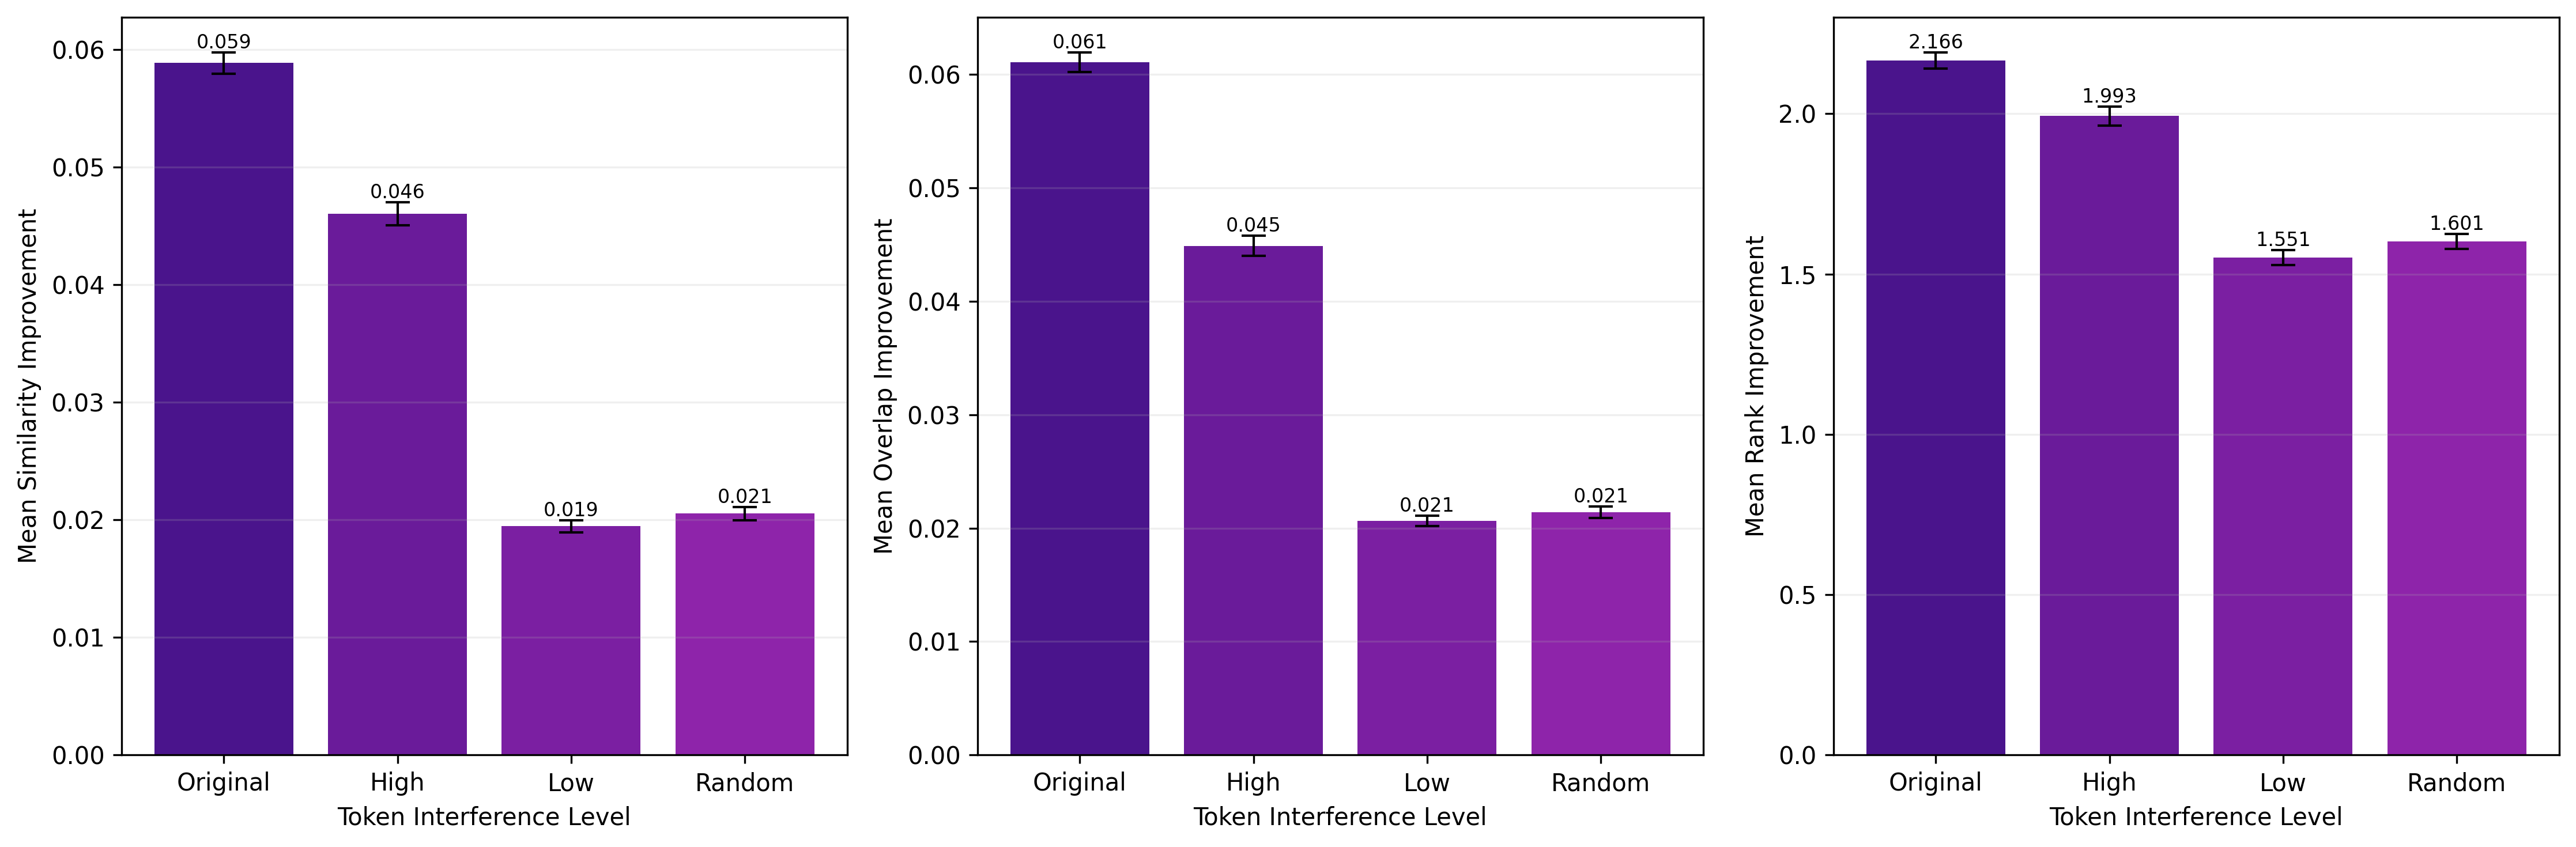

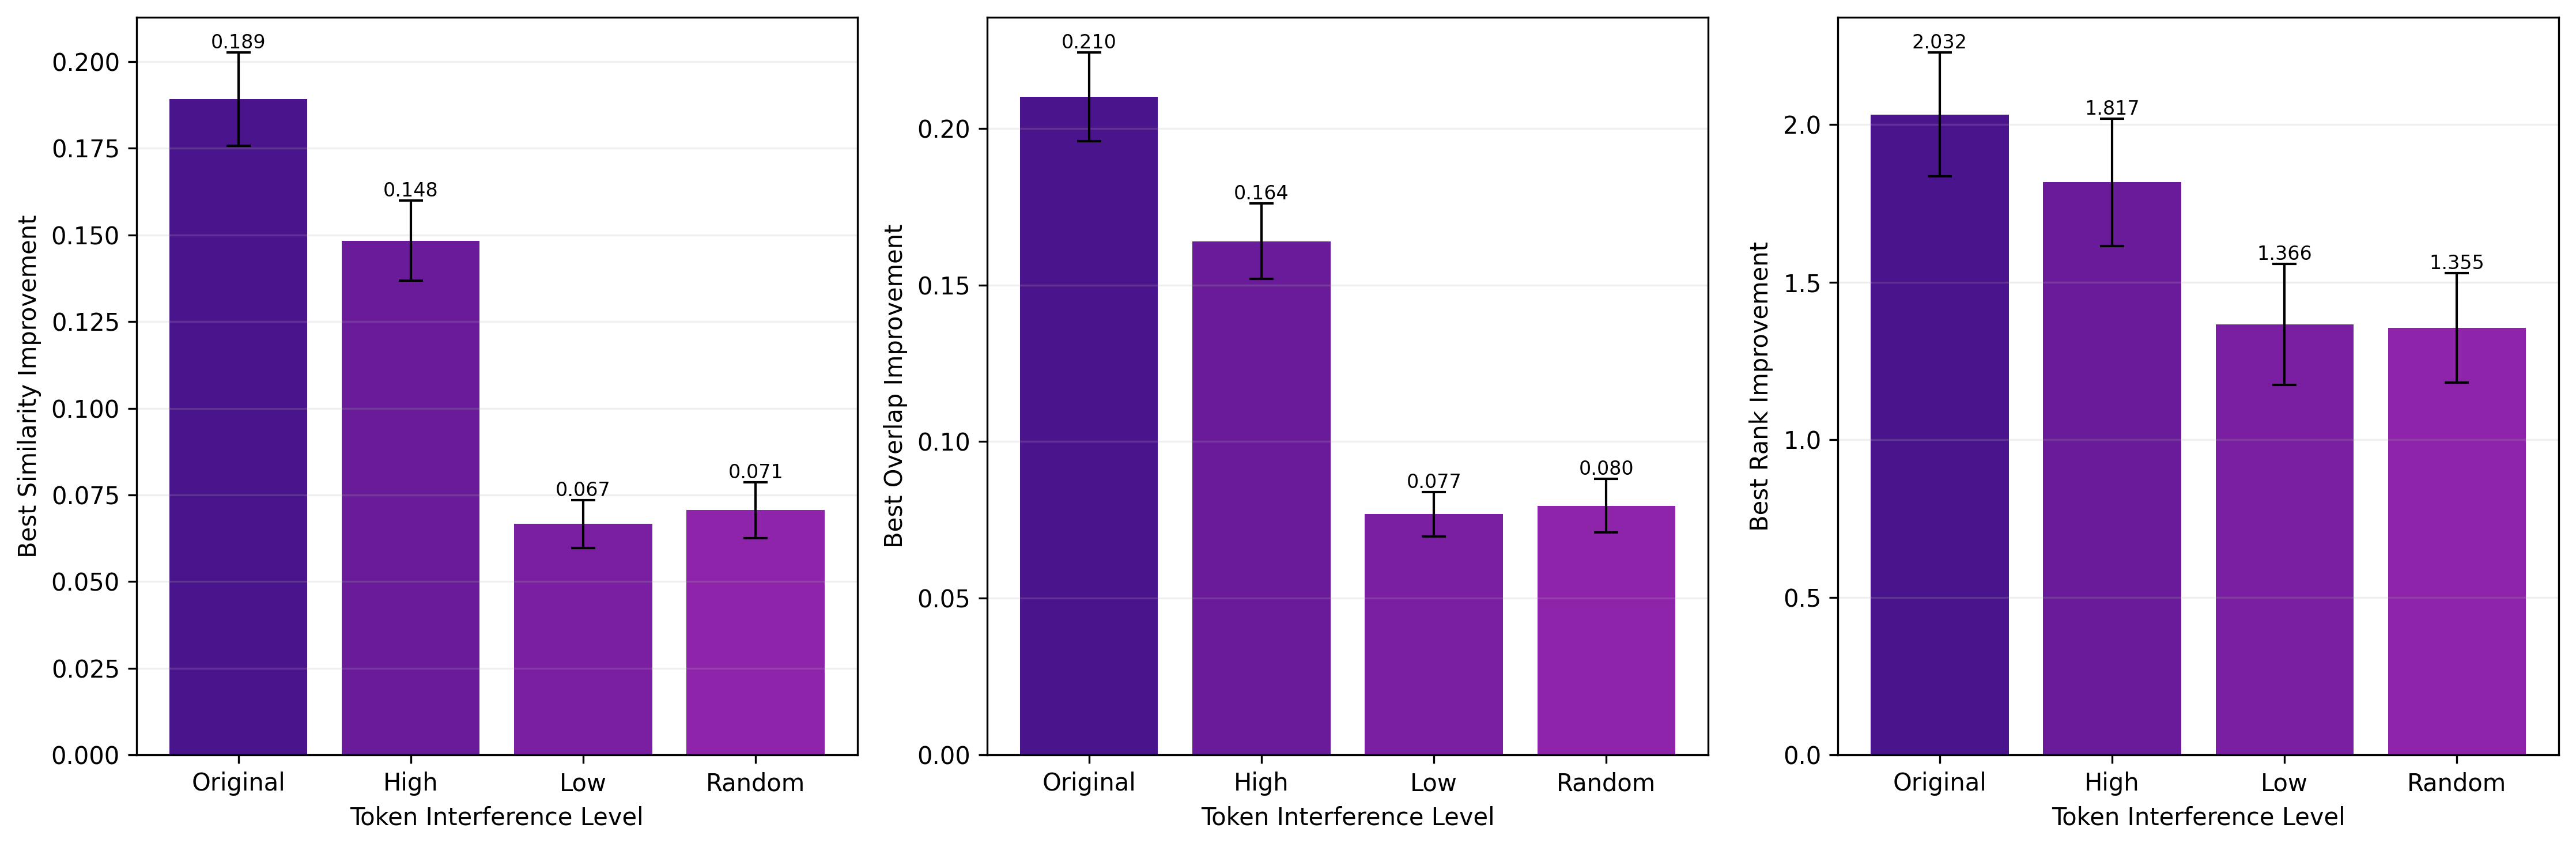

In [7]:
# Analyze location results
print("\n=== Location Experiments Analysis ===")
compare_all_groups(llama_location_results, 'location', "llama")
print_experiment_results(llama_location_results, "llama", "location")
plot_injection_metrics(llama_location_results, "llama", "location")
plot_best_improvements(llama_location_results, "llama", "location")

In [6]:
# Run location experiments
n_trials = 100

gemma_location_ids = []
for token in location_token_sets['target']:
    token_id = tokenizer(token, add_special_tokens=False)['input_ids']
    if token_id:
        gemma_location_ids.append(token_id[0])

# Run Gemma location experiments
print("\n=== Running Gemma Location Experiments ===")
gemma_location_results = {token_type: [] for token_type in location_token_sets.keys()}

for sentence in tqdm(location_sentences[:100]):
    torch.cuda.empty_cache()
    
    for token_type, tokens in location_token_sets.items():
        results = run_injection_experiment(
            gemma, tokenizer, sentence,
            tokens, n_trials, gemma_location_ids
        )
        gemma_location_results[token_type].append({
            'sentence': sentence,
            'results': results
        })


=== Running Gemma Location Experiments ===


  0%|          | 0/100 [00:00<?, ?it/s]

The 'batch_size' argument of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'max_batch_size' argument instead.
The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.



=== Location Experiments Analysis ===

=== gemma location Statistical Analysis ===

Target vs Random:
Difference: 0.2376
p-value: 0.0000
Statistical significance: difference is significant (p = 0.0000)

High Interference vs Random:
Difference: 0.1123
p-value: 0.0000
Statistical significance: difference is significant (p = 0.0000)

Medium Interference vs Random:
Difference: -0.0006
p-value: 0.9065
Statistical significance: difference is not significant (p = 0.9065)

=== gemma location Experiment Results ===

target:
Top-10 token count increase rate: 39.21% (3921/10000)
Top-10 token probability sum increase rate: 63.85% (6385/10000)

high_interference:
Top-10 token count increase rate: 26.68% (2668/10000)
Top-10 token probability sum increase rate: 50.24% (5024/10000)

medium_interference:
Top-10 token count increase rate: 15.39% (1539/10000)
Top-10 token probability sum increase rate: 31.44% (3144/10000)

random:
Top-10 token count increase rate: 15.45% (1545/10000)
Top-10 token probab

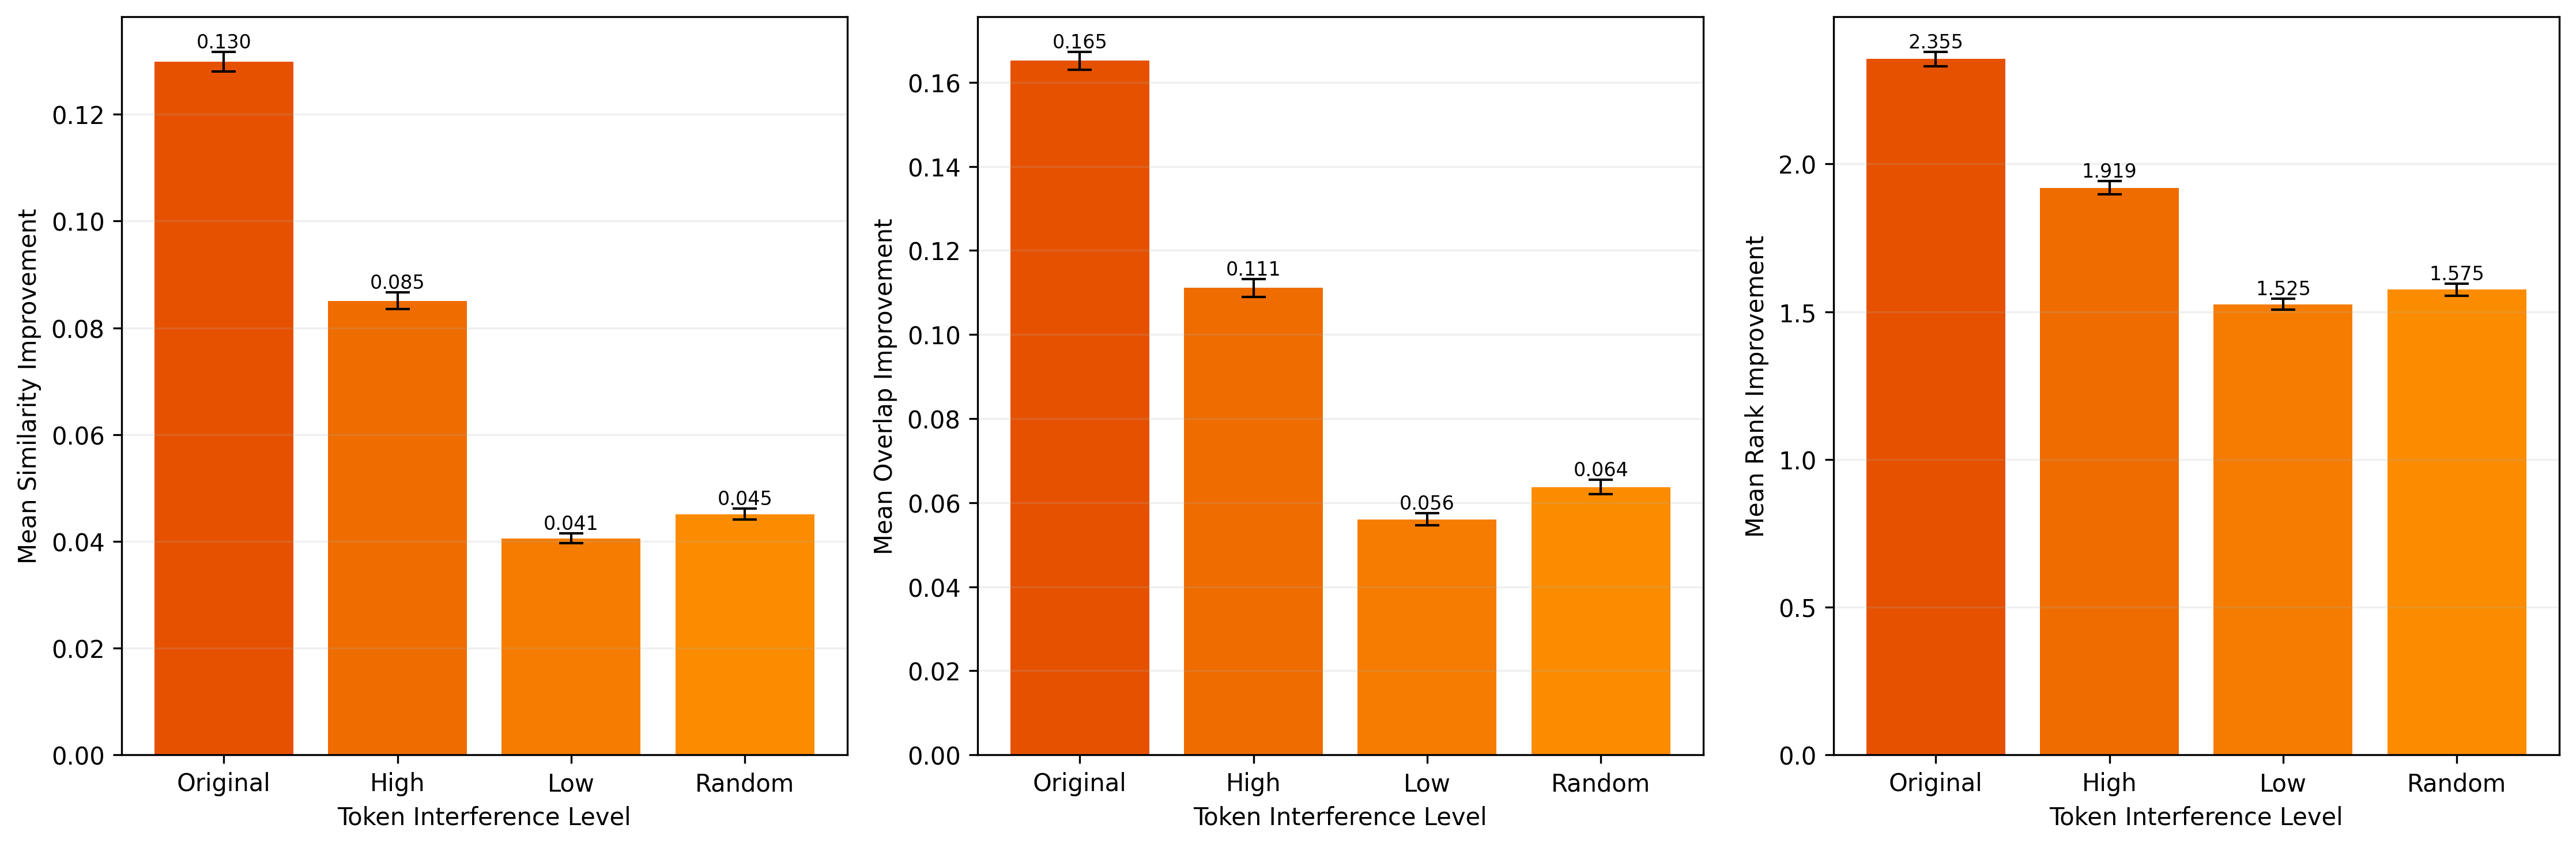

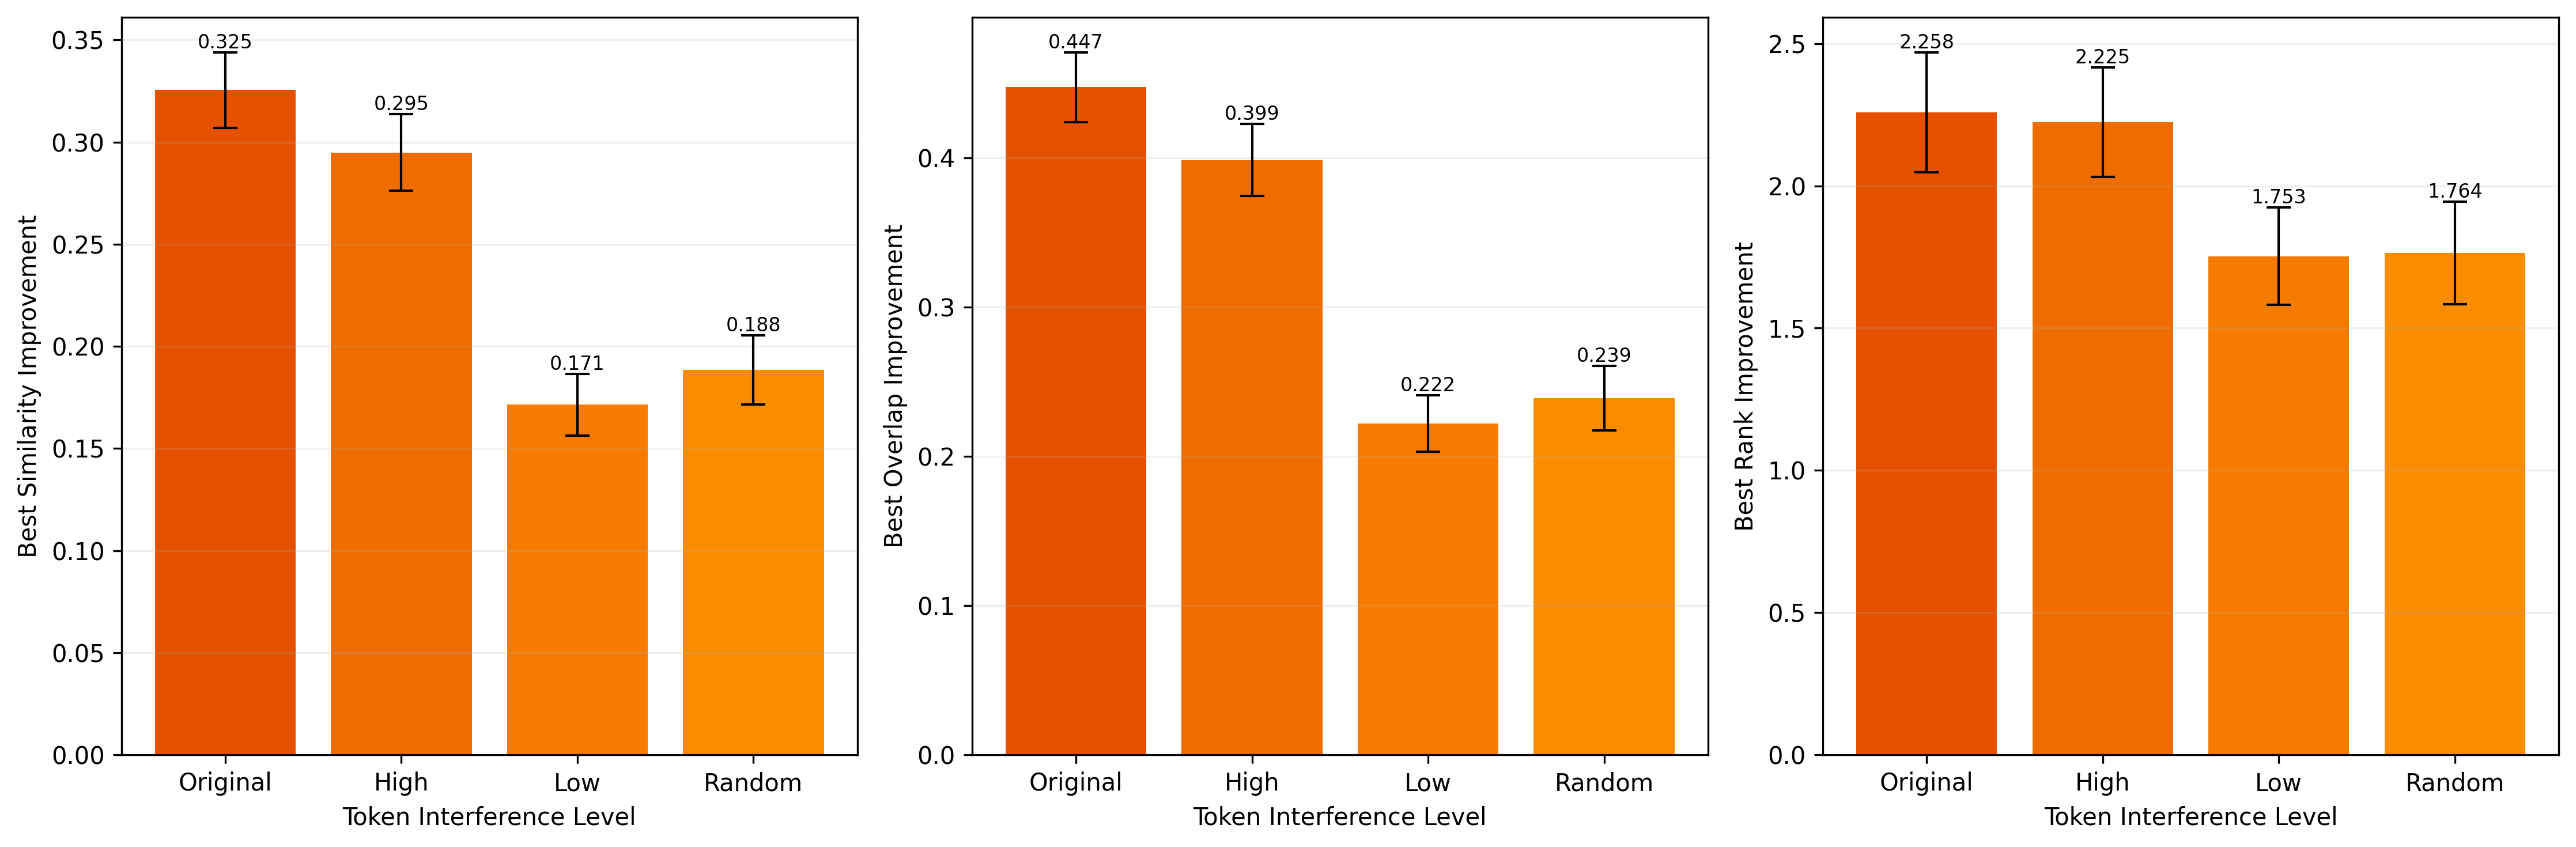

In [16]:
# Analyze location results
print("\n=== Location Experiments Analysis ===")
compare_all_groups(gemma_location_results, 'location', "gemma")
print_experiment_results(gemma_location_results, "gemma", "location")
plot_injection_metrics(gemma_location_results, "gemma", "location")
plot_best_improvements(gemma_location_results, "gemma", "location")

### Love & Hate Experiment

In [8]:
# Load love/hate interference data
with open('./corpus/pythia_non_love_interference.json', 'r') as f:
    pythia_non_love_interference = json.load(f)
with open('./corpus/gpt2_non_love_interference.json', 'r') as f:
    gpt2_non_love_interference = json.load(f)

# Define love hate tokens
love_hate_tokens = [
    ' hate', ' hated', ' hates', ' dislike', ' love', ' hatred', 
    ' loved', ' disdain', ' LOVE', 'love', ' disrespect', 'Love', 
    ' Love', 'liked', ' loves', ' scorn', ' anger', ' liked', ' like',
    ' hostility', ' liking', ' resentment', ' kill', ' resent', 
    ' outrage', 'ophobia'
]

# Get high/medium interference tokens intersection for love/hate
pythia_love_high = set()
pythia_love_low = set()
for layer_type, layer_data in pythia_non_love_interference.items():
    for layer_id, pairs in layer_data.items():
        for pair in pairs:
            if pair['interference_value'] > 0.5:
                pythia_love_high.add(pair['interfering_token'])
            elif pair['interference_value'] > 0.2:
                pythia_love_low.add(pair['interfering_token'])

gpt2_love_high = set()
gpt2_love_low = set()
for layer_type, layer_data in gpt2_non_love_interference.items():
    for layer_id, pairs in layer_data.items():
        for pair in pairs:
            if pair['interference_value'] > 0.5:
                gpt2_love_high.add(pair['interfering_token'])
            elif pair['interference_value'] > 0.2:
                gpt2_love_low.add(pair['interfering_token'])

# Get common interference tokens
common_love_high_interference = list(pythia_love_high & gpt2_love_high)
common_love_medium_interference = list(pythia_love_low & gpt2_love_low)

# Get common random tokens
common_love_random = list(
    set(pythia_token_str_type.keys()) & set(gpt2_token_str_type.keys()) - 
    set(love_hate_tokens) - set(common_love_high_interference) - 
    set(common_love_medium_interference)
)

# Prepare token sets for love/hate experiments
love_hate_token_sets = {
    'target': love_hate_tokens,
    'high_interference': common_love_high_interference,
    'medium_interference': common_love_medium_interference,
    'random': common_love_random
}

print("\n=== Love/Hate Token Sets Statistics ===")
print(f"Target tokens: {len(love_hate_token_sets['target'])}")
print(f"Common high interference tokens: {len(love_hate_token_sets['high_interference'])}")
print(f"Common medium interference tokens: {len(love_hate_token_sets['medium_interference'])}")
print(f"Common random tokens: {len(love_hate_token_sets['random'])}")


=== Love/Hate Token Sets Statistics ===
Target tokens: 26
Common high interference tokens: 82
Common medium interference tokens: 6997
Common random tokens: 29380


In [9]:
# Run love/hate experiments
n_trials = 100

# Convert love/hate tokens to IDs for both models
llama_love_hate_ids = []
for token in love_hate_token_sets['target']:
    token_id = tokenizer(token, add_special_tokens=False)['input_ids']
    if token_id:
        llama_love_hate_ids.append(token_id[0])

# Run Llama love/hate experiments
print("\n=== Running Llama Love/Hate Experiments ===")
llama_love_hate_results = {token_type: [] for token_type in love_hate_token_sets.keys()}

for sentence in tqdm(love_hate_sentences[:100]):
    torch.cuda.empty_cache()
    
    for token_type, tokens in love_hate_token_sets.items():
        results = run_injection_experiment(
            llama, tokenizer, sentence,
            tokens, n_trials, llama_love_hate_ids
        )
        llama_love_hate_results[token_type].append({
            'sentence': sentence,
            'results': results
        })


=== Running Llama Love/Hate Experiments ===


  0%|          | 0/100 [00:00<?, ?it/s]


=== Love/Hate Experiments Analysis ===

=== llama love_hate Statistical Analysis ===

Target vs Random:
Difference: 0.5038
p-value: 0.0000
Statistical significance: difference is significant (p = 0.0000)

High Interference vs Random:
Difference: 0.0554
p-value: 0.0000
Statistical significance: difference is significant (p = 0.0000)

Medium Interference vs Random:
Difference: 0.0074
p-value: 0.0284
Statistical significance: difference is significant (p = 0.0284)

=== llama love&Hate Experiment Results ===

target:
Top-10 token count increase rate: 56.08% (5608/10000)
Top-10 token probability sum increase rate: 54.40% (5440/10000)

high_interference:
Top-10 token count increase rate: 11.24% (1124/10000)
Top-10 token probability sum increase rate: 11.67% (1167/10000)

medium_interference:
Top-10 token count increase rate: 6.44% (644/10000)
Top-10 token probability sum increase rate: 6.16% (616/10000)

random:
Top-10 token count increase rate: 5.70% (570/10000)
Top-10 token probability su

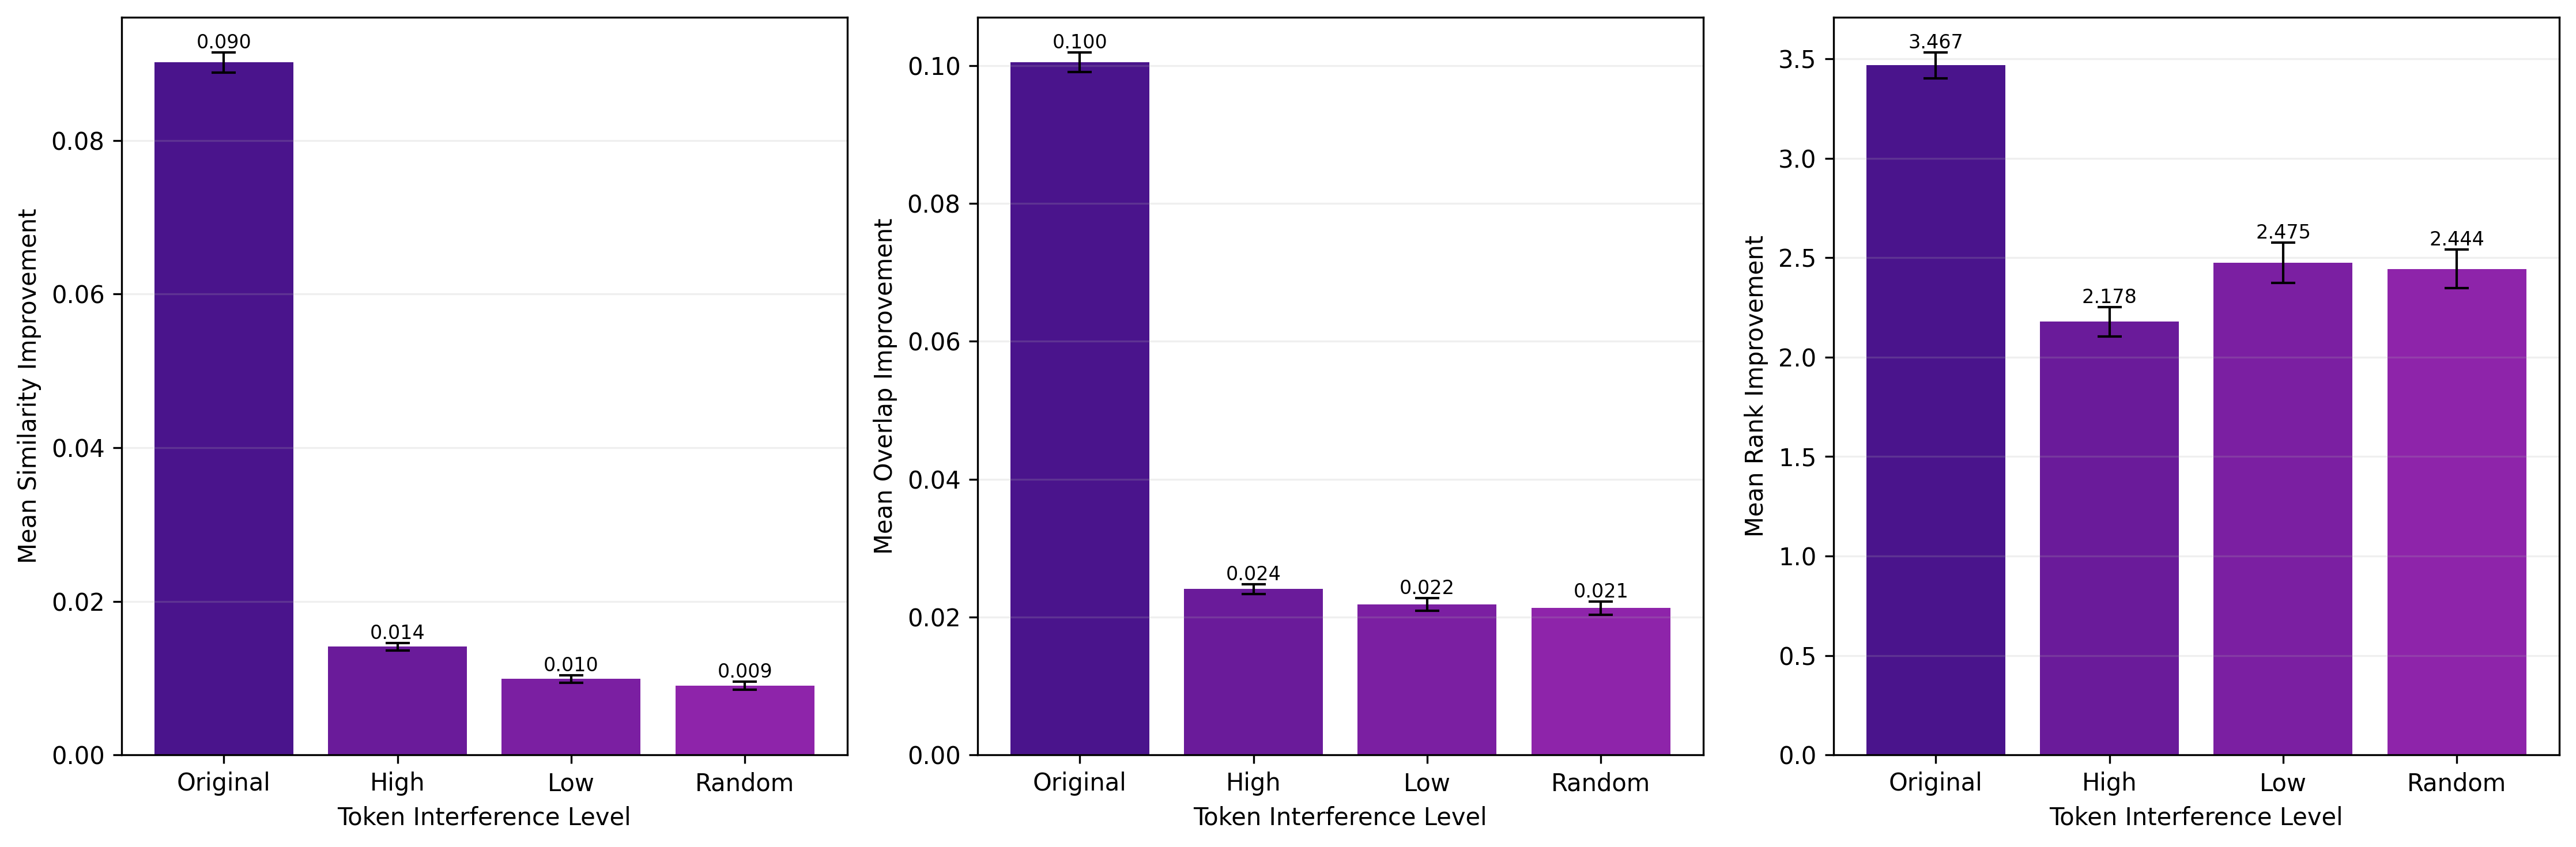

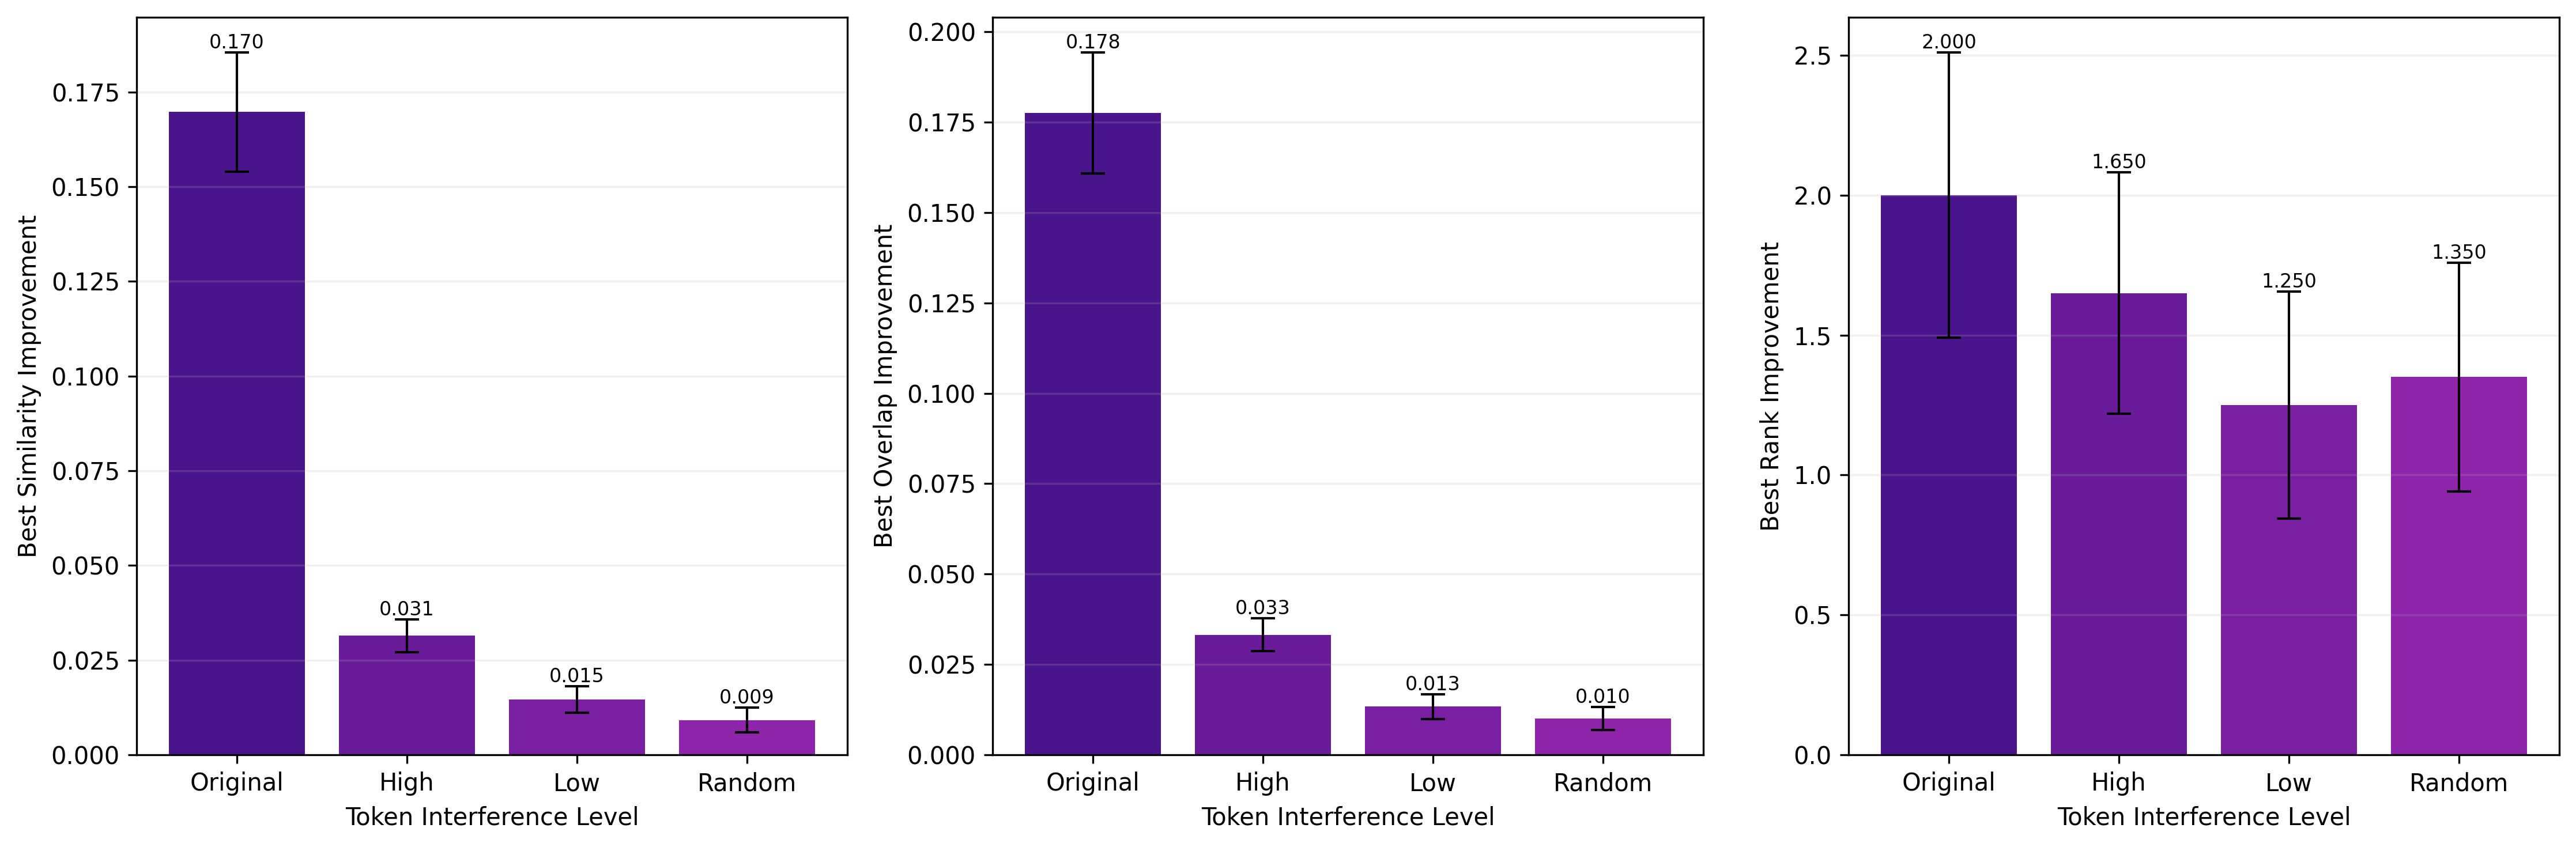

In [10]:
# Analyze love/hate results
print("\n=== Love/Hate Experiments Analysis ===")
compare_all_groups(llama_love_hate_results, 'love_hate', "llama")
print_experiment_results(llama_love_hate_results, "llama", "love&Hate")
plot_injection_metrics(llama_love_hate_results, "llama", "love&Hate")
plot_best_improvements(llama_love_hate_results, "llama", "love&Hate")

In [9]:
# Run love/hate experiments
n_trials = 100

gemma_love_hate_ids = []
for token in love_hate_token_sets['target']:
    token_id = tokenizer(token, add_special_tokens=False)['input_ids']
    if token_id:
        gemma_love_hate_ids.append(token_id[0])

# Run Gemma love/hate experiments
print("\n=== Running Gemma Love/Hate Experiments ===")
gemma_love_hate_results = {token_type: [] for token_type in love_hate_token_sets.keys()}

for sentence in tqdm(love_hate_sentences[:100]):
    torch.cuda.empty_cache()
    
    for token_type, tokens in love_hate_token_sets.items():
        results = run_injection_experiment(
            gemma, tokenizer, sentence,
            tokens, n_trials, gemma_love_hate_ids
        )
        gemma_love_hate_results[token_type].append({
            'sentence': sentence,
            'results': results
        })


=== Running Gemma Love/Hate Experiments ===


  0%|          | 0/100 [00:00<?, ?it/s]


=== Love/Hate Experiments Analysis ===

=== gemma love_hate Statistical Analysis ===

Target vs Random:
Difference: 0.4377
p-value: 0.0000
Statistical significance: difference is significant (p = 0.0000)

High Interference vs Random:
Difference: 0.0525
p-value: 0.0000
Statistical significance: difference is significant (p = 0.0000)

Medium Interference vs Random:
Difference: 0.0032
p-value: 0.3808
Statistical significance: difference is not significant (p = 0.3808)

=== gemma love&hate Experiment Results ===

target:
Top-10 token count increase rate: 50.79% (5079/10000)
Top-10 token probability sum increase rate: 52.80% (5280/10000)

high_interference:
Top-10 token count increase rate: 12.27% (1227/10000)
Top-10 token probability sum increase rate: 19.57% (1957/10000)

medium_interference:
Top-10 token count increase rate: 7.34% (734/10000)
Top-10 token probability sum increase rate: 12.16% (1216/10000)

random:
Top-10 token count increase rate: 7.02% (702/10000)
Top-10 token probabil

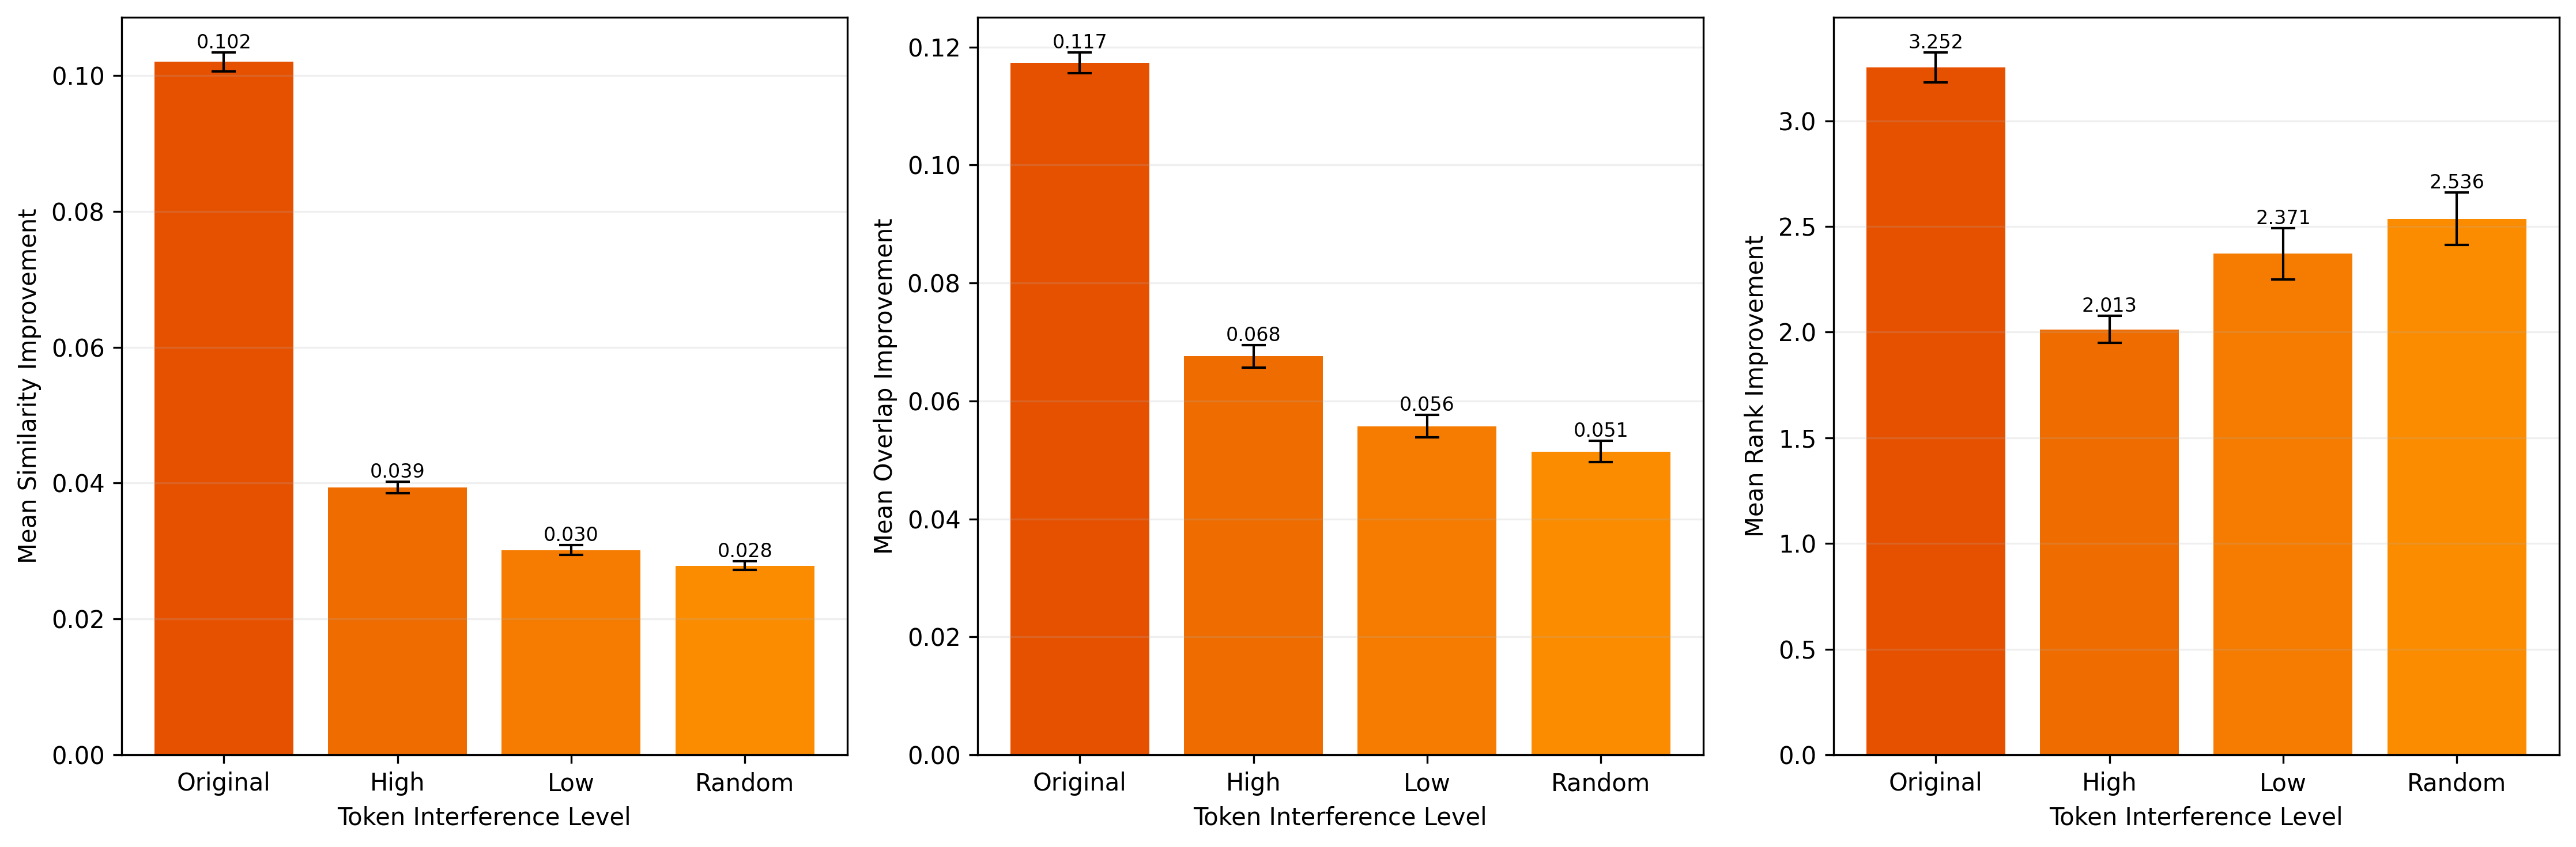

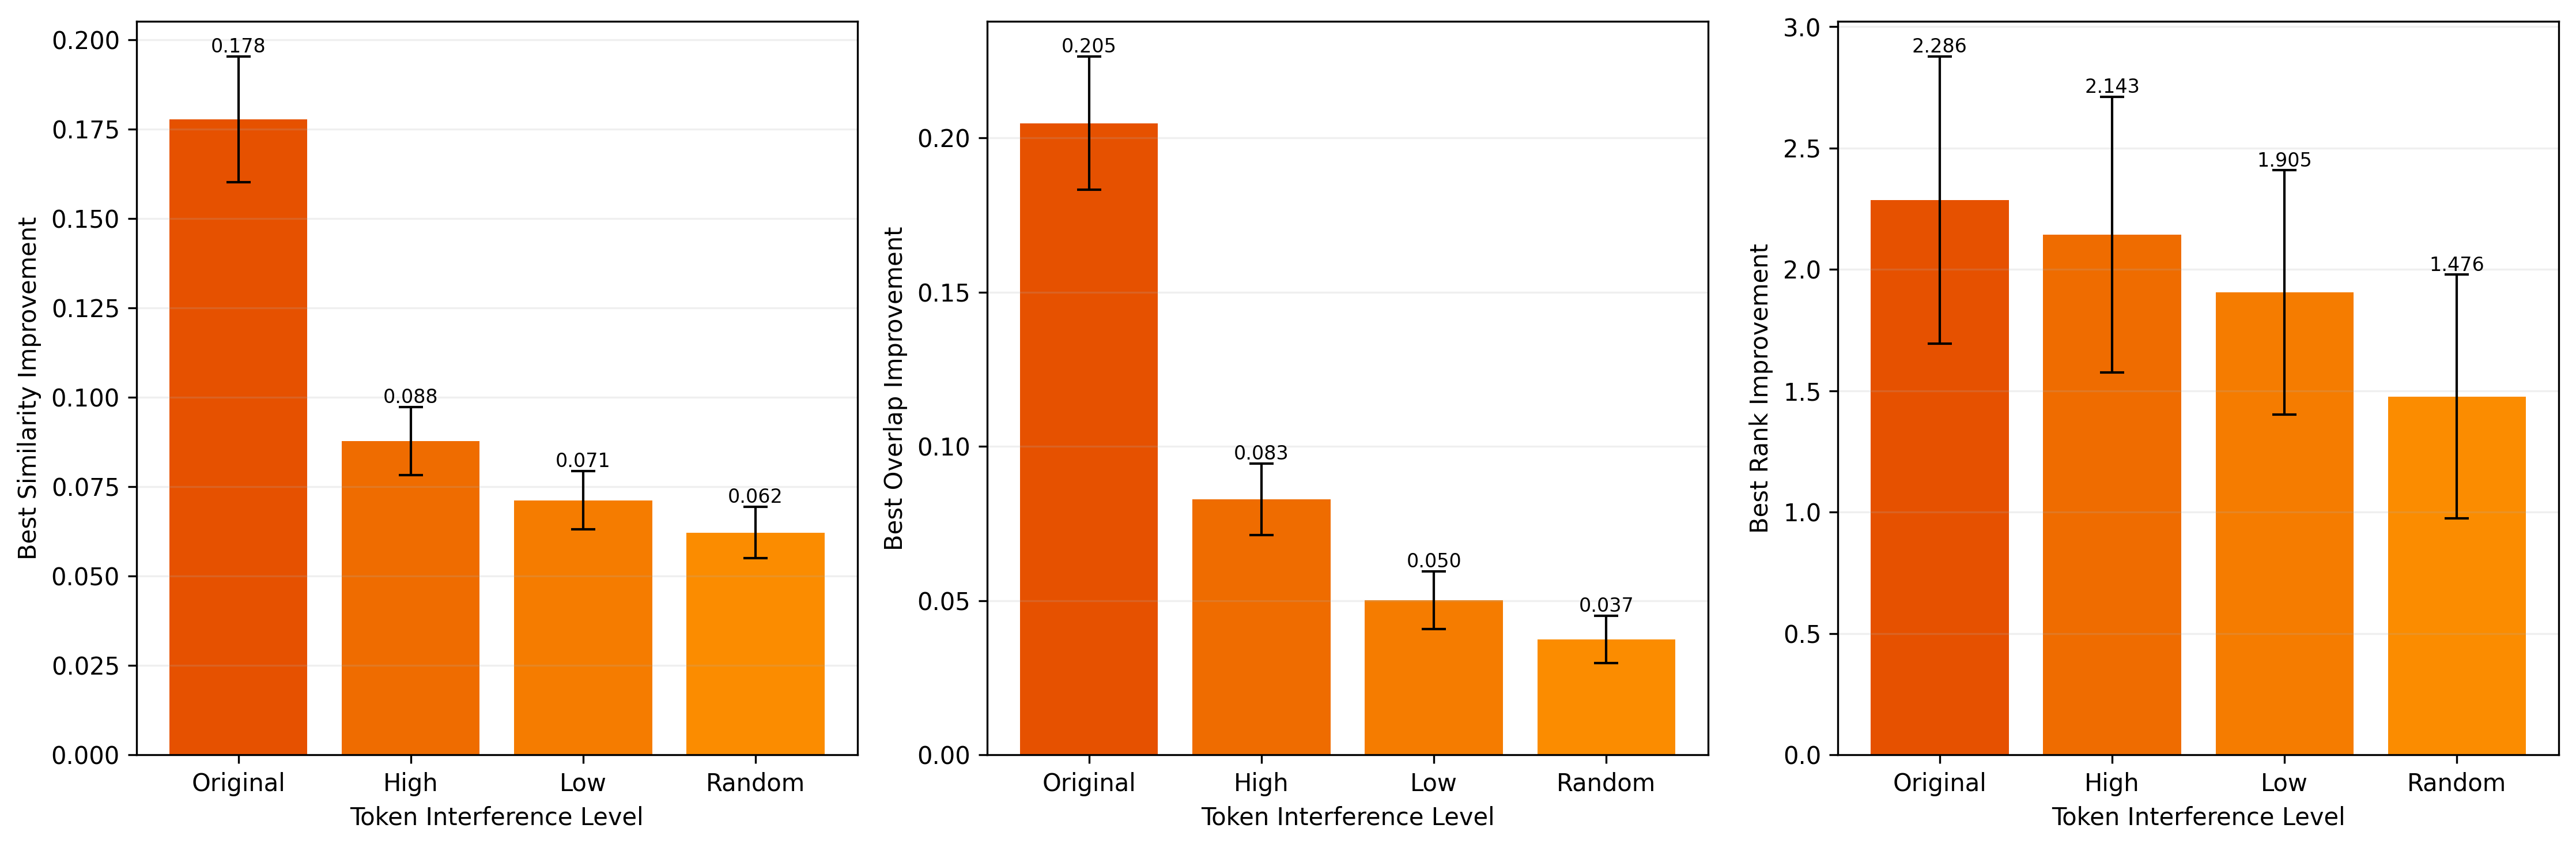

In [17]:
# Analyze love/hate results
print("\n=== Love/Hate Experiments Analysis ===")
compare_all_groups(gemma_love_hate_results, 'love_hate', "gemma")
print_experiment_results(gemma_love_hate_results, "gemma", "love&hate")
plot_injection_metrics(gemma_love_hate_results, "gemma", "love&hate")
plot_best_improvements(gemma_love_hate_results, "gemma", "love&hate")